# Problem 2 - Generative Adversarial Networks Continues... Contain part 4

In [1]:
import pandas as pd
import numpy as np
import string
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [2]:
# Prepare torch gpu
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Using GPU device
gpu_device = torch.device("cuda:0")

True
Tesla K80


### Loading data into tensor

In [3]:
# Transform to tensors
fmnist_transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# Loading the training data for use
fmnist = datasets.FashionMNIST(root="./fashion_mnist", train = True, transform = fmnist_transform, download = True)
data_loader = DataLoader(dataset = fmnist, batch_size = 32, shuffle = True, num_workers = 0)

In [5]:
# Create reverse dictionary
reverse_lookup = {x:y for y,x in data_loader.dataset.class_to_idx.items()}

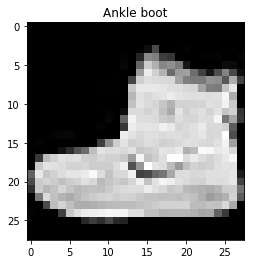

In [6]:
# Plotting the first example to see
_ = plt.imshow(data_loader.dataset.data[0], "gray")
_ = plt.title(reverse_lookup[data_loader.dataset.targets[0].detach().numpy().item()])

In [7]:
reverse_lookup

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
def show_images_with_labels(torch_gpu_tensors, torch_gpu_labels):
    fig = plt.figure(figsize=(14,18))
    labels = torch_gpu_labels.cpu().numpy()
    for i in range(len(torch_gpu_labels)):
        p = i + 1
        axes = fig.add_subplot(6,5,p)
        plt.imshow(convert_d(torch_gpu_tensors, "1>2")[i].cpu().detach().numpy(), "gray")
        axes.set_title(reverse_lookup[labels[i]])
    plt.show()

## Part 4 - Conditional GAN (10 points)

In [9]:
# Convert from 2d to 1d and 1d to 2d
def convert_d(inputs, mode):
    if mode == "2>1":
        return inputs.view(inputs.size(0), 784)
    elif mode == "1>2":
        return inputs.view(inputs.size(0), 28, 28)
    else:
        return None

In [10]:
# Function to generate random noise
def random_noise(n):
    return torch.randn((n, 32))

In [11]:
def one_hot_tensor(num_labels):
    eye = torch.eye(10).to(gpu_device)
    return eye[num_labels]

In [12]:
def concat_labels_stuff(images, tensor_labels):
    return torch.cat([images, tensor_labels], dim = 1)

In [13]:
# The vannila generator with 3 hidden layers and 1 output layer
class conditional_gen(nn.Module):
    def __init__(self):
        super(conditional_gen, self).__init__()
        # Input the noise with 64 values
        self.hidden1 = nn.Sequential(nn.Linear(42, 64), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(64, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(512, 784), nn.Tanh())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [14]:
# Generator training function
def train_conditional_gen(gen_optimizer, generated_data):
    gen_optimizer.zero_grad()
    p = conditional_dis_model(generated_data)
    loss = conditional_loss(p, Variable(torch.ones(generated_data.size(0), 1)).to(gpu_device))
    loss.backward()
    gen_optimizer.step()
    return loss

In [15]:
# The discriminator for the vannila gan
class conditional_dis(nn.Module):
    def __init__(self):
        super(conditional_dis, self).__init__()
        # Input the image with 784 + 10 one hot vector
        self.hidden1 = nn.Sequential(nn.Linear(794, 512), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 64), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [16]:
# Discriminator training funciton
def train_conditional_dis(dis_optimizer, real_data, generated_data):
    dis_optimizer.zero_grad()
    # Train with real data
    p_real = conditional_dis_model(real_data)
    loss_real = conditional_loss(p_real, Variable(torch.ones(real_data.size(0), 1)).to(gpu_device))
    loss_real.backward()
    # Train with generated data
    p_gen = conditional_dis_model(generated_data)
    loss_generated = conditional_loss(p_gen, Variable(torch.zeros(generated_data.size(0), 1)).to(gpu_device))
    loss_generated.backward()
    
    dis_optimizer.step()
    
    return loss_real + loss_generated, p_real, p_gen

In [17]:
# The training function
def train_conditional(gen_model, dis_model, dataloader, gen_optimizer, dis_optimizer, num_epochs):
    # Timing
    time_start = int(round(time.time() * 1000))
    
    # Run all the epochs
    gen_img = []
    gen_labels = []
    all_dis_loss = []
    all_gen_loss = []
    gen_model.train()
    dis_model.train()
    display_epoch = [1, 5, 10, 15, 20, 25, 30, 35]
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dis_loss = 0.0
        gen_loss = 0.0

        # Load data from dataloader
        for i, data in enumerate(data_loader, 0):
            image_data, real_labels = data[0].to(gpu_device), data[1].to(gpu_device)
            batch_size = image_data.size(0)
            
            real_data = concat_labels_stuff(Variable(convert_d(image_data, "2>1")).to(gpu_device),
                                             one_hot_tensor(real_labels))
            # Train Discriminator
            # Generate random class and noise
            noise_0 = random_noise(batch_size).to(gpu_device)
            random_class_0 = torch.LongTensor(batch_size).random_(0, 10).to(gpu_device)
            random_class_v_0 = one_hot_tensor(random_class_0)
            concat_0 = concat_labels_stuff(noise_0, random_class_v_0)
            with torch.no_grad():
                generated_data = gen_model(concat_0).detach()
            generated_data_combined = concat_labels_stuff(generated_data, random_class_v_0)
            
            d_loss, d_p_real, d_p_generated = train_conditional_dis(dis_optimizer, real_data, generated_data_combined)
            
            # Train Genereator
            # Generate random class and noise
            noise_1 = random_noise(batch_size).to(gpu_device)
            random_class_1 = torch.LongTensor(batch_size).random_(0, 10).to(gpu_device)
            random_class_v_1 = one_hot_tensor(random_class_1)
            concat_1 = concat_labels_stuff(noise_1, random_class_v_1)
            
            generated_images = gen_model(concat_1)
            generated_images_combined = concat_labels_stuff(generated_images, random_class_v_1)
            
            g_loss = train_conditional_gen(gen_optimizer, generated_images_combined)

            # Add to loss and accuracy
            dis_loss += d_loss.item()
            gen_loss += g_loss.item()

        epoch_dis_loss = dis_loss / dataloader.dataset.data.size(0)
        epoch_gen_loss = gen_loss / dataloader.dataset.data.size(0)

        all_dis_loss.append(epoch_dis_loss)
        all_gen_loss.append(epoch_gen_loss)

        # Printing logs
        clear_output()
        print("Epoch", str(epoch + 1), "/", str(num_epochs))
        print("Discriminator Loss:", epoch_dis_loss)
        print("Generator Loss:", epoch_gen_loss)

        noise_2 = random_noise(30).to(gpu_device)
        random_class_2 = torch.LongTensor([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9]).to(gpu_device)
        random_class_v_2 = one_hot_tensor(random_class_2)
        concat_2 = concat_labels_stuff(noise_2, random_class_v_2)

        with torch.no_grad():
            gen_images = gen_model(concat_2).detach()
            
        show_images_with_labels(gen_images, random_class_2)

        if (epoch + 1) in display_epoch:
            gen_img.append(gen_images)
            gen_labels.append(random_class_2)

        run_loss = 0.0
        run_correct = 0
    
    time_elapsed = int(round(time.time() * 1000)) - time_start
    print ('Total training time is {}ms'.format(time_elapsed))
    return all_dis_loss, all_gen_loss, gen_img, gen_labels

In [18]:
# Set up models and solvers and loss for training
conditional_gen_model = conditional_gen()
conditional_gen_model.to(gpu_device)

conditional_dis_model = conditional_dis()
conditional_dis_model.to(gpu_device)

conditional_loss = nn.BCELoss()
conditional_gen_sgd = optim.Adam(conditional_gen_model.parameters(), lr = 0.00015)
conditional_dis_sgd = optim.Adam(conditional_dis_model.parameters(), lr = 0.00015)

Epoch 35 / 35
Discriminator Loss: 0.029534493371844293
Generator Loss: 0.042884953672687215


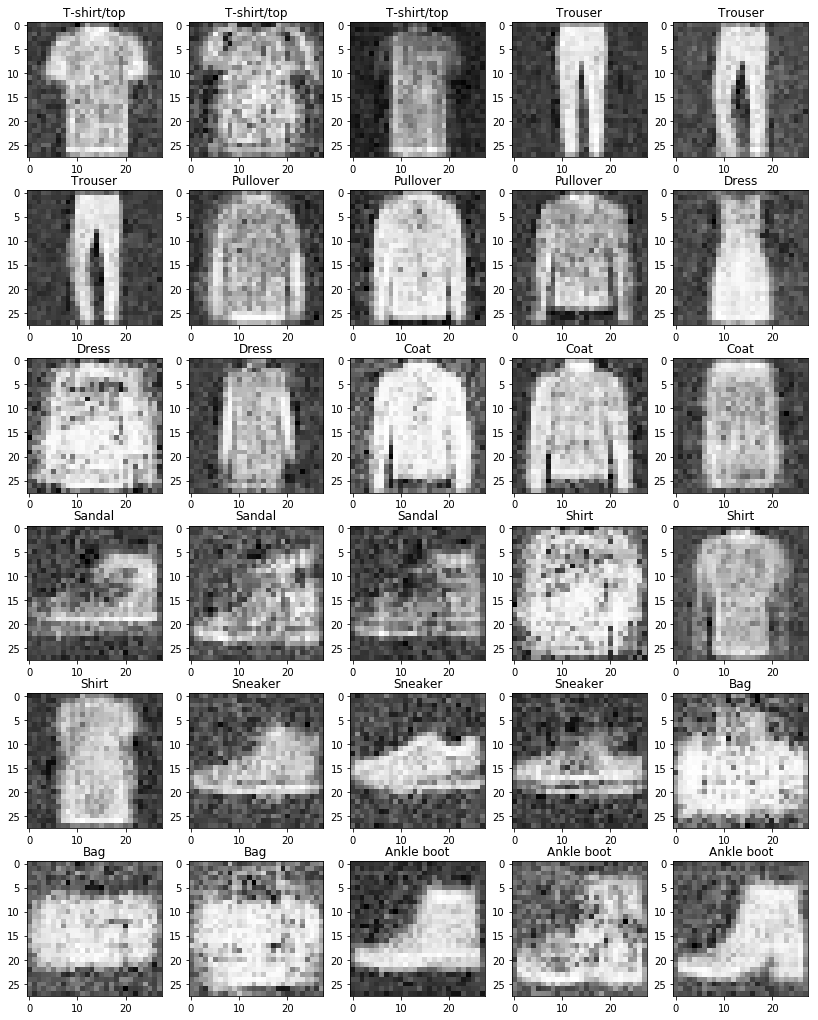

Total training time is 966221ms


In [19]:
c_dis_loss, c_gen_loss, c_gen_pic, c_gen_labels = train_conditional(conditional_gen_model, conditional_dis_model,
                                                  data_loader, conditional_gen_sgd, conditional_dis_sgd, 35)

In [20]:
# Save model
torch.save(conditional_gen_model.state_dict(), "./conditional_gen_v2.pth")
torch.save(conditional_dis_model.state_dict(), "./conditional_dis_v2.pth")

In [21]:
# # Load model
# conditional_gen_model = conditional_gen()
# conditional_gen_model.load_state_dict(torch.load("./conditional_gen.pth"))
# conditional_dis_model = conditional_dis()
# conditional_dis_model.load_state_dict(torch.load("./conditional_dis.pth"))

In [22]:
# Save data
store_c_loss = pd.DataFrame({"Discriminator_loss": c_dis_loss, "Generator_loss": c_gen_loss})
store_c_loss.to_csv("conditional_result_v2.csv", index = False)
store_c_pic = pd.DataFrame(c_gen_pic)
store_c_pic.to_csv("conditional_pic_v2.csv", index = False)
store_c_label = pd.DataFrame(c_gen_labels)
store_c_label.to_csv("conditional_labels_v2.csv", index = False)

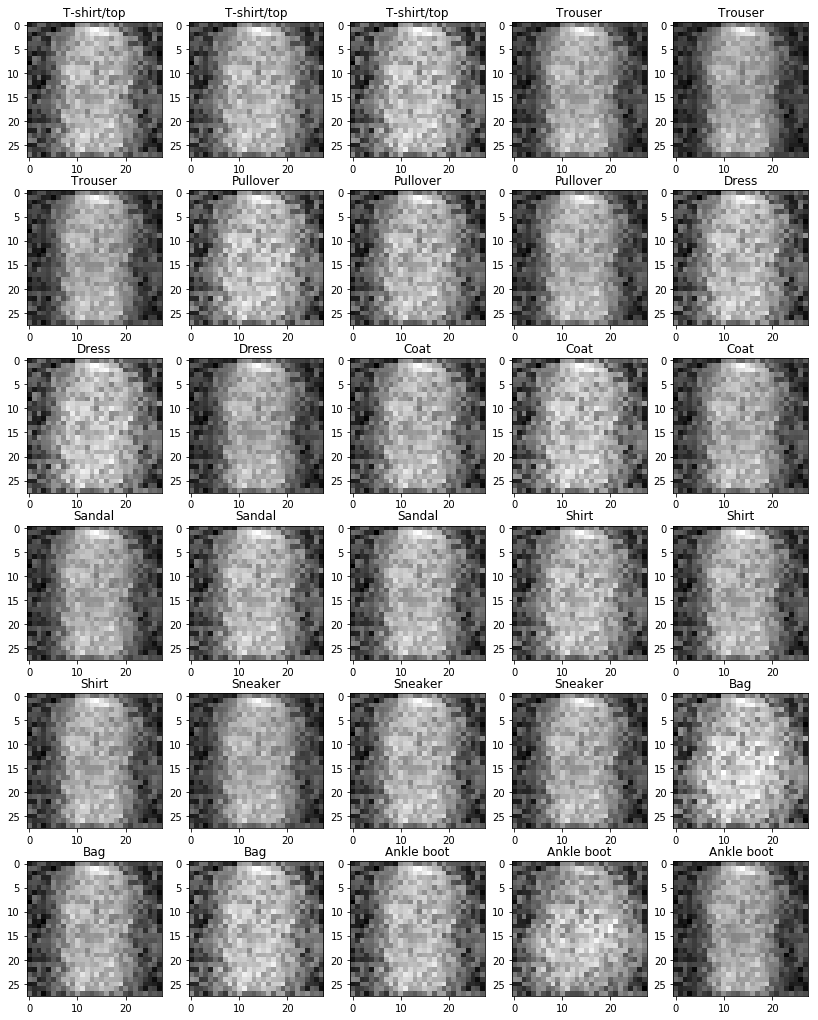

In [23]:
show_images_with_labels(c_gen_pic[0], c_gen_labels[0])

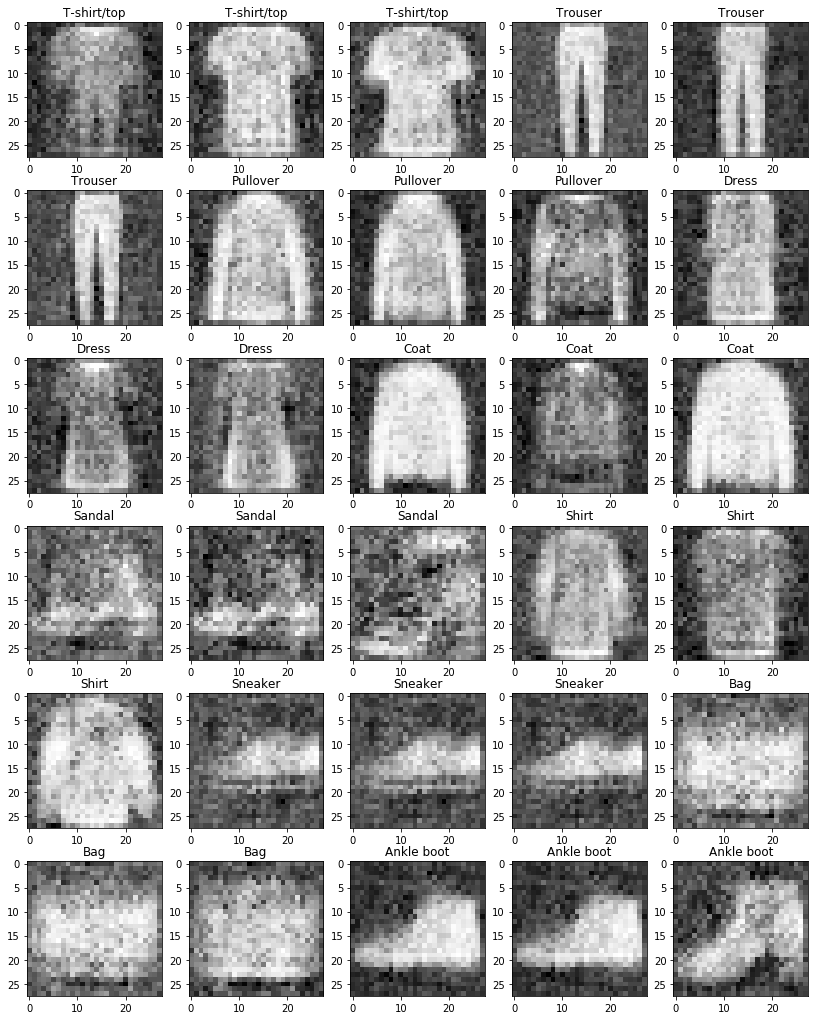

In [24]:
show_images_with_labels(c_gen_pic[len(c_gen_pic)//2 - 1], c_gen_labels[len(c_gen_labels)//2 - 1])

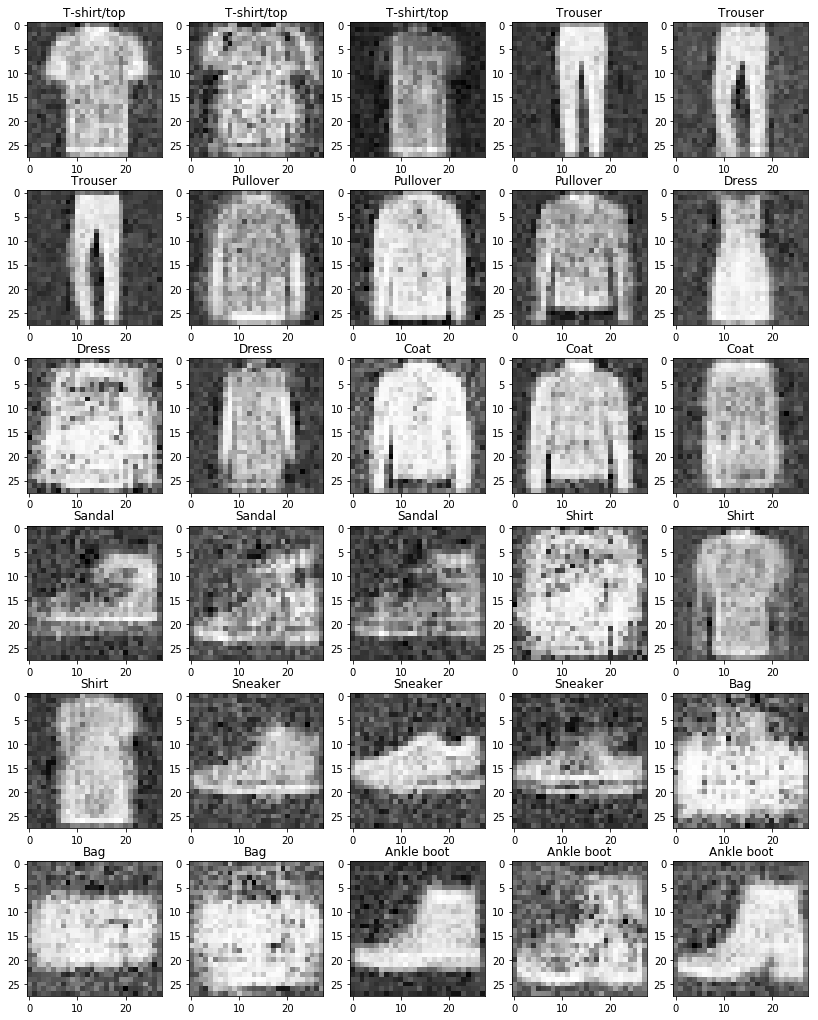

In [25]:
show_images_with_labels(c_gen_pic[-1], c_gen_labels[-1])

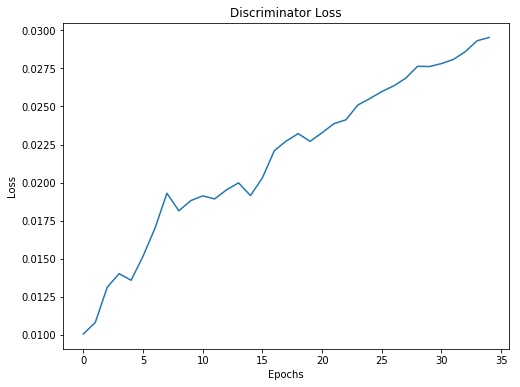

In [26]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(c_dis_loss)), c_dis_loss)
_ = plt.title("Discriminator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

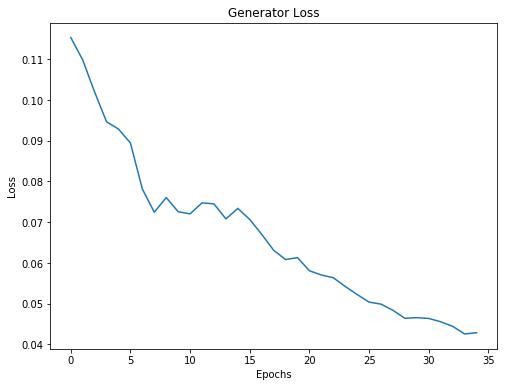

In [27]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(c_gen_loss)), c_gen_loss)
_ = plt.title("Generator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

In [28]:
noise_t = random_noise(30).to(gpu_device)
random_class_t = torch.LongTensor([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9]).to(gpu_device)
random_class_v_t = one_hot_tensor(random_class_t)
concat_t = concat_labels_stuff(noise_t, random_class_v_t)

with torch.no_grad():
    gen_images_t = conditional_gen_model(concat_t).detach()

In [29]:
data_loader.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

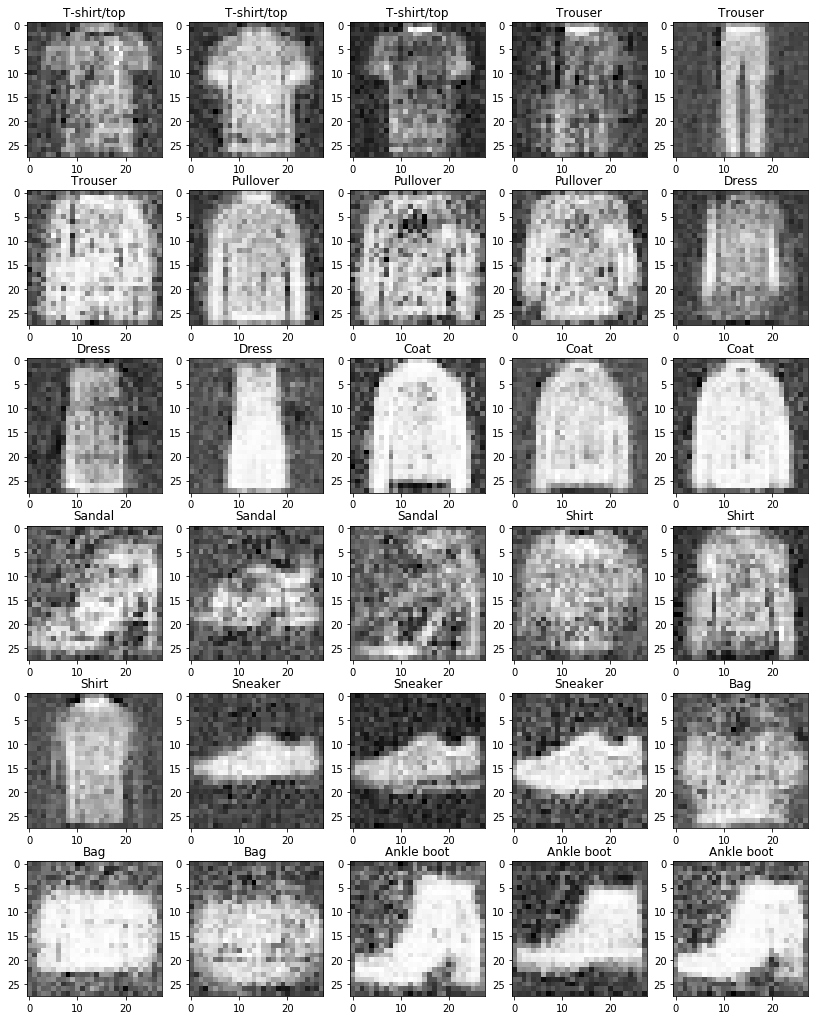

In [30]:
show_images_with_labels(gen_images_t, random_class_t)